In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm

In [2]:
def simulate_simple_markov_chain(N, mu, sigma, alpha, beta):
    
    #Simple lambda to sample from a Markov chain, given a current state x
    markov_sample = lambda x: np.random.choice(range(3), size = 1, p = probs[x])[0]
    initial_probs = np.array([0.7, 0.3, 0])
    state = np.random.choice(range(3), size = 1, p = initial_probs)[0]
    y = [0]
    for t in range(1,N):
        curr_p = alpha*np.exp(beta*t/20)
        if curr_p > 1:
            print(i, curr_p)
        probs = np.array([[(0.95-curr_p), 0.05, curr_p], 
                          [0.1, 0.85, 0.05]
                         ]
                        )
        state = markov_sample(state)
        if state == 0:
            dy = np.abs(np.random.normal(size = 1, loc = mu[0], scale = sigma[0]))[0]
            y.append(y[t-1] + dy)
        elif state == 1:
            dy = np.abs(np.random.normal(size = 1, loc = mu[1], scale = sigma[1]))[0]
            y.append(y[t-1] + dy)
        elif state == 2:
            dy = np.random.normal(size = 1, loc = mu[2], scale = sigma[2])[0]
            y.append(y[t-1] + dy)
            break
    return y

In [3]:
true_alpha = np.exp(-7)
true_beta = 0.1
true_mu = np.array([0.2, 0, -5])
true_sigma = np.array([0.1, 0.01, 0.01])

In [4]:
simulated_process = []
for i in range(100):
    simulated_process.append(simulate_simple_markov_chain(N=1000,
                                                          mu=true_mu,
                                                          sigma=true_sigma,
                                                          alpha=true_alpha,
                                                          beta=true_beta))

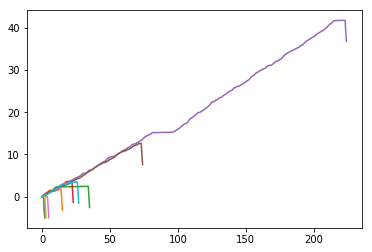

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(10):
    plt.plot(simulated_process[i])

In [6]:
df = pd.DataFrame(simulated_process)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,0,0.203573,-4.799966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.243284,0.472255,0.781245,0.996963,1.363866,1.536800,1.560435,1.563079,1.565686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.129937,0.292675,0.576701,0.644638,0.903060,1.098875,1.259991,1.464124,1.933067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0.361437,0.598257,0.825470,1.024634,1.206637,1.349268,1.405348,1.510741,1.693676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0.029103,0.134146,0.412852,0.590070,0.867226,1.008580,1.215564,1.273558,1.277016,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
import pymc3 as pm
import theano.tensor as tt
import theano

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [8]:
eta_ = tt.dtensor3("eta_")
eta0 = np.random.rand(100, 1000, 3)
eta_.tag.test_value = eta0

xi_ = tt.dmatrix("xi_")
xi_.tag.test_value = np.array([[1, 0, 0]] * 100)
xi_out = tt.dmatrix("xi_out")
xi_out.tag.test_value = np.array([[1, 0, 0]] * 100)
print(xi_out.tag.test_value.shape)
ft_out = tt.dvector("ft_out")
ft_out.tag.test_value = np.array([0] * 100)
print(ft_out.tag.test_value.shape)

(100, 3)
(100,)


In [9]:
p = np.zeros((100, 1000, 2, 3))
for i in range(100):
    for j in range(1000):
        p[i, j, 0, 0] = 0.95 - np.exp(-6) * np.exp(0.05*j/20)
        p[i, j, 0, 1] = 0.05
        p[i, j, 0, 2] = np.exp(-6) * np.exp(0.05*j/20)
        p[i, j, 1, 0] = 0.01
        p[i, j, 1, 1] = 0.94
        p[i, j, 1, 2] = 0.05

In [10]:
P_curr = p[:, 0]

In [11]:
ft2 = np.zeros((100, 1000))
xi2 = np.zeros((100, 1000, 3))

In [12]:
def ftfunc(P_curr, xi, eta):
    xi2 = eta * (np.dot(P_curr.T, xi[0:2]))
    return xi2

In [13]:
for i in range(100):
    xi2[i, 0] = ftfunc(p[i, 0], np.asarray([1, 0, 0]), eta0[i, 0])

In [14]:
xi2.shape

(100, 1000, 3)

In [15]:
ft2[:, 0] = xi2[:, 0].sum(axis=1)

In [16]:
xi2[:, 0, 0] = xi2[:, 0, 0]/ft2[:, 0]
xi2[:, 0, 1] = xi2[:, 0, 1]/ft2[:, 0]
xi2[:, 0, 2] = xi2[:, 0, 2]/ft2[:, 0]

In [17]:
for i in range(100):
    for j in range(1, 1000):
        P_curr = p[i, j]
        Eta = eta0[i, j]
        Xi_ = xi2[i, j - 1]
        xi2[i, j] = ftfunc(P_curr, Xi_, Eta)
        ft2[:, j] = xi2[:, j].sum(axis=1)
        xi2[:, j, 0] = xi2[:, j, 0]/ft2[:, j]
        xi2[:, j, 1] = xi2[:, j, 1]/ft2[:, j]
        xi2[:, j, 2] = xi2[:, j, 2]/ft2[:, j]

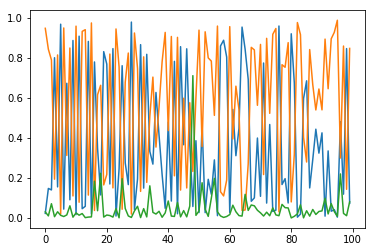

In [18]:
plt.plot(xi2[:, 99, :])

In [19]:
np.max(xi2)

0.9993245363088045

In [20]:
def likelihood_per_timepoint_(eta_i_j, p_i_j, ft_i_prev_j, x_i_prev_j):
    #Xi1 = (p_i_j[0, 0] * x_i_prev_j[0] + p_i_j[1, 0] * x_i_prev_j[1]) * eta_i_j[0]
    #Xi2 = (p_i_j[0, 1] * x_i_prev_j[0] + p_i_j[1, 1] * x_i_prev_j[1]) * eta_i_j[1]
    #Xi3 = (p_i_j[0, 2] * x_i_prev_j[0] + p_i_j[1, 2] * x_i_prev_j[1]) * eta_i_j[2]
    Xi = eta_i_j * (tt.dot(p_i_j.T, x_i_prev_j[0:2]))
    #ft = Xi1 + Xi2 + Xi3
    ft = Xi.sum()
    #x_i_j = tt.stack([Xi1, Xi2, Xi3])/ft
    x_i_j = Xi/ft
    return [ft, x_i_j]

In [21]:
def likelihood_per_timepoint(eta_curr, p_curr, ft_prev, xi_prev):
    xi_k_out = tt.dvector("xi_k_out")
    xi_k_out.tag.test_value = np.array([1, 0, 0])
    ft_k_out = tt.dscalar("ft_k_out")
    ft_k_out.tag.test_value = theano.shared(0.)

    ([ft_curr, xi_curr], updates) = theano.scan(fn=likelihood_per_timepoint_,
                                                sequences=[eta_curr, p_curr],
                                                outputs_info=[ft_k_out, xi_k_out])
    
    return [ft_curr, xi_curr]

In [22]:
eta_curr = tt.dmatrix("eta_curr")
eta_curr.tag.test_value = eta0[0]
p_curr = tt.dtensor3("p_curr")
p_curr.tag.test_value = p[0]

print(eta_curr.tag.test_value.shape)
print(eta0[0].shape, p[0].shape)
ft_init = np.array([[0.] * 1000] * 100)
xi_init = np.array([[[1., 0., 0.]]*1000] * 100 )
print(ft_init.shape, xi_init.shape)

test1, test2 = likelihood_per_timepoint(tt.as_tensor_variable(eta0[i]), tt.as_tensor_variable(p[i]),  
                                              tt.as_tensor_variable(ft_init), tt.as_tensor_variable(xi_init))

(1000, 3)
(1000, 3) (1000, 2, 3)
(100, 1000) (100, 1000, 3)


In [23]:
p_ = tt.dtensor4("p_")
p_.tag.test_value = p

In [24]:
M = tt.matrix('M')
alpha = 0.5
beta = 0.25
p2 = 0.1
M0 = np.stack([beta*np.ones(9), 
               beta*np.ones(9),
               beta*np.ones(9)], axis=1)
M.tag.test_value = M0
s = tt.vector('s')
s0 = np.array([beta, 1, 1])
s.tag.test_value = s0

def step(m_row, cumulative_product):
    return m_row * cumulative_product

output, updates = theano.scan(fn=step,
                              sequences=[M],
                              outputs_info=[s])
probs_with_time = theano.function(inputs=[M, s],
                                  outputs=output,
                                  updates=updates)
probs_with_time(M0, s0)

array([[6.25000000e-02, 2.50000000e-01, 2.50000000e-01],
       [1.56250000e-02, 6.25000000e-02, 6.25000000e-02],
       [3.90625000e-03, 1.56250000e-02, 1.56250000e-02],
       [9.76562500e-04, 3.90625000e-03, 3.90625000e-03],
       [2.44140625e-04, 9.76562500e-04, 9.76562500e-04],
       [6.10351562e-05, 2.44140625e-04, 2.44140625e-04],
       [1.52587891e-05, 6.10351562e-05, 6.10351562e-05],
       [3.81469727e-06, 1.52587891e-05, 1.52587891e-05],
       [9.53674316e-07, 3.81469727e-06, 3.81469727e-06]])

In [27]:
theano.config.print_test_value = True
with pm.Model() as m:
    # Transition matrix
    BoundedNormal = pm.Bound(pm.Normal, lower=-30, upper=0)
    BoundedNormal2 = pm.Bound(pm.Normal, lower=0, upper=0.5)
    logalpha = BoundedNormal('logalpha', mu=0, sd=10)
    beta =  BoundedNormal2('beta', mu=0, sd=0.5)
    
    BoundedNormal3 = pm.Bound(pm.Normal, lower=0, upper=0.05)
    p1 = BoundedNormal3('p1', sd=1)
    p2 = pm.Dirichlet('p2', a=np.array([1, 10, 1]))
    
    # eta
    alpha = pm.Normal('alpha', mu=0., sd=1, shape=3)
    sigma = pm.HalfCauchy('sigma', beta=1., shape=3)
    xi_init = pm.Dirichlet('xi_init', a=np.array([3, 1, 0]))
    Xi =[]
    potential = tt.dscalar('potential')
    potential = 0
    eta1, eta2, eta3 = tt.zeros(df.shape), tt.zeros(df.shape), tt.zeros(df.shape)
    n = df.shape[0]
    m = df.shape[1]
    P = tt.zeros((n, m, 2, 3))
    P = tt.set_subtensor(P[:, :, 0, 0],
                         tt.ones_like(eta1)*tt.exp(beta/4))
    P = tt.set_subtensor(P[:, :, 0, 1],
                         tt.ones_like(eta1))
    P = tt.set_subtensor(P[:, :, 0, 2],
                         tt.ones_like(eta1))
    P = tt.set_subtensor(P[:, :, 1, 0],
                          tt.ones_like(eta1))
    P = tt.set_subtensor(P[:, :, 1, 1],
                          tt.ones_like(eta1))
    P = tt.set_subtensor(P[:, :, 1, 2],
                          tt.ones_like(eta1))
    xi_out = tt.zeros((100, 3))
    for i in range(n):
        print(i)
        eta1 = tt.set_subtensor(eta1[i, 0], 
                                tt.exp(pm.Normal.dist(mu=alpha[0], 
                                                      sd=sigma[0])
                                       .logp(df.values[i, 0])))
        eta2 = tt.set_subtensor(eta2[i, 0], 
                                tt.exp(pm.Normal.dist(mu=alpha[1], 
                                                      sd=sigma[1])
                                       .logp(df.values[i, 0])))
        eta3 = tt.set_subtensor(eta3[i, 0], 
                                tt.exp(pm.Normal.dist(mu=alpha[2], 
                                                      sd=sigma[2])
                                       .logp(df.values[i, 0])))
        indices = np.where(np.isnan(df.values[i]))[0]
        if indices.shape[0] == 0:
            m = df.values[i].shape[0]
        else:
            m = indices[0]
        eta1 = tt.set_subtensor(eta1[i, 1:m],
                                tt.exp(pm.Normal.dist(mu=alpha[0] + df.values[i, :(m-1)], 
                                                      sd=sigma[0])
                                       .logp(df.values[i, 1:m])))
        eta2 = tt.set_subtensor(eta2[i, 1:m], 
                                tt.exp(pm.Normal.dist(mu=alpha[1] + df.values[i, :(m-1)], 
                                                      sd=sigma[1])
                                       .logp(df.values[i, 1:m])))
        eta3 = tt.set_subtensor(eta3[i, 1:m], 
                                tt.exp(pm.Normal.dist(mu=alpha[2] + df.values[i, :(m-1)],
                                                      sd=sigma[2])
                                       .logp(df.values[i, 1:m])))
    
        P = tt.set_subtensor(P[i, 0, 0, 2], tt.exp(logalpha))
        P = tt.set_subtensor(P[i, 0, 0, 1], p1)
        P = tt.set_subtensor(P[i, 0, 0, 0], (1-p1-tt.exp(logalpha)))
        P = tt.set_subtensor(P[i, 0, 1, :], p2[:])
        s = np.ones((2, 3))
        temp_P, updates = theano.scan(fn=step,
                                     sequences=[P[i]],
                                     outputs_info=[s])
        P = tt.set_subtensor(P[i], temp_P)
        xi_out = tt.set_subtensor(xi_out[i], xi_init)
    eta = tt.stack([eta1, eta2, eta3], axis=2)
    ft_init = tt.zeros((100))
    
    ([ft, xi], updates) = theano.scan(fn=likelihood_per_timepoint,
                                      sequences=[eta, P, ft_init, xi_out])

    potential = tt.sum(tt.log(ft))
        # likelihood `target += sum(log(f))`
    pm.Potential('likelihood', potential)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


TypeError: For compute_test_value, one input test value does not have the requested type.
 
Backtrace when that variable is created:

  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/anurag/pymc3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-8348ddd5974f>", line 83, in <module>
    sequences=[eta, P, ft_init, xi_out])
  File "/home/anurag/pymc3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "<ipython-input-21-ecc58b797f31>", line 4, in likelihood_per_timepoint
    ft_k_out = tt.dscalar("ft_k_out")

The error when converting the test value to that variable type:
Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?

In [ ]:
from scipy import optimize

In [ ]:
with m:
    start = pm.find_MAP(fmin=optimize.fmin_powell)
    trace = pm.sample(1000, tune=1000, cores=4, init="adapt_diag", start=start)

In [ ]:
pm.traceplot(trace)